# Importing needed libraries

In [1]:
!pip install tensorflow-addons


In [2]:
import os
import zipfile
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
import random
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Function to plot the confusion matrix

In [9]:
def plot_confusion_matrix(y_true, y_pred, class_labels, set_name):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(4, 4))
    sns.set(font_scale=0.8)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)


    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {set_name}')

    plt.show()

# Function to randomly display an image for each category in the dataframe

In [10]:
def display_random_images(data):
    subdirectories = ['Shepherds_Purse', 'Maize', 'Common_Chickweed', 'Cleavers']
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))

    for i, subdir in enumerate(subdirectories):

        subset = data[data['Label'] == subdir]
        random_row = subset.sample(1)
        random_image = random_row.iloc[0]['Image']

        axes[i].imshow(random_image)
        axes[i].set_title(subdir)
        axes[i].axis('off')

    plt.show()


# Read the zip file from google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
zip_file_path = 'https://drive.google.com/file/d/1G5McbePuVyH2_xTpLY79qb1j_ZVZIJqL/view?usp=sharing'

if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        print("Files in ZIP file:")
        for file in file_list:
            print(file)

## Extract the content from the zip file

In [5]:
zip_file_path = '/content/drive/MyDrive/a3_dataset.zip'
extraction_path = '/content'


os.makedirs(extraction_path, exist_ok=True)

# Extract the contents of the zip folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Contents of '{zip_file_path}' have been successfully extracted to '{extraction_path}'.")


Contents of '/content/drive/MyDrive/a3_dataset.zip' have been successfully extracted to '/content'.


# Read the images from the folders with their label and resize them

In [6]:
img_directory = '/content/a3_dataset/img'
subdirectories = ['Shepherds_Purse', 'Maize', 'Common_Chickweed', 'Cleavers']

images = []
labels = []
image_filenames = []

for label, subdir in enumerate(subdirectories):
    subdir_path = os.path.join(img_directory, subdir)

    image_files = [f for f in os.listdir(subdir_path) if f.endswith('.png')]

    for image_file in image_files:
        image_path = os.path.join(subdir_path, image_file)

        # Read and process the image
        image = io.imread(image_path)


        images.append(image)
        labels.append(label)
        image_filenames.append(image_file)

images = np.array(images)
resized_images = [resize(img, (128, 128)) for img in images]
label_mapping = {
    0: 'Shepherds_Purse',
    1: 'Maize',
    2: 'Common_Chickweed',
    3: 'Cleavers'
}

labels = [label_mapping[label] for label in labels]
data = pd.DataFrame({'Image': images, 'Resized Image' : resized_images , 'Label': labels, 'Image Filename': image_filenames})

In [7]:
data

,Image,Resized Image,Label,Image Filename
0,"[[[191, 191, 197], [189, 190, 195], [186, 188,...","[[[0.7315501534306406, 0.7415909812618043, 0.7...",Shepherds_Purse,31.png
1,"[[[81, 63, 49], [84, 63, 45], [92, 69, 50], [9...","[[[0.31829445034849874, 0.24628158270144, 0.18...",Shepherds_Purse,217.png
2,"[[[101, 83, 65], [107, 91, 73], [116, 99, 82],...","[[[0.4123674775930652, 0.34440545819356855, 0....",Shepherds_Purse,45.png
3,"[[[160, 164, 165], [160, 165, 166], [160, 165,...","[[[0.6255237654143688, 0.6412071078431372, 0.6...",Shepherds_Purse,241.png
4,"[[[62, 51, 29], [57, 46, 26], [63, 52, 33], [6...","[[[0.24680893841911763, 0.2028751148897059, 0....",Shepherds_Purse,46.png
...,...,...,...,...
995,"[[[100, 86, 69], [103, 89, 70], [104, 90, 70],...","[[[0.3892626676813086, 0.33232302972162653, 0....",Cleavers,231.png
996,"[[[80, 65, 50], [69, 53, 38], [74, 59, 44], [7...","[[[0.29453517578431354, 0.23455214807732436, 0...",Cleavers,105.png
997,"[[[107, 91, 76], [115, 100, 85], [106, 89, 73]...","[[[0.40905821688041294, 0.3454079119749525, 0....",Cleavers,76.png
998,"[[[82, 61, 41], [85, 64, 45], [84, 65, 47], [8...","[[[0.32264571844362744, 0.24029277726715684, 0...",Cleavers,0.png


In [8]:
data["Resized Image"][0].shape

(128, 128, 3)

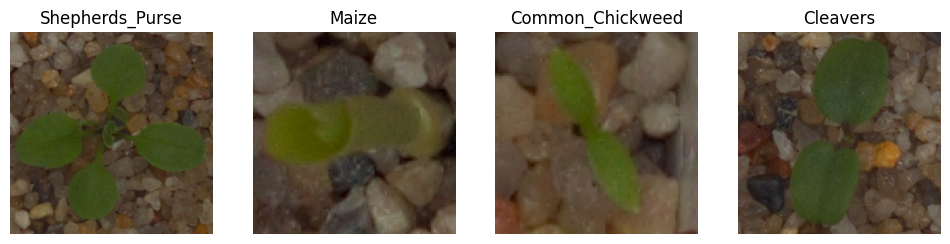

In [11]:
display_random_images(data)

## Mapping the string categories to integers

In [12]:
label_mapping = {
    0: 'Shepherds_Purse',
    1: 'Maize',
    2: 'Common_Chickweed',
    3: 'Cleavers'
}

reverse_label_mapping = {v: k for k, v in label_mapping.items()}

data['Label'] = data['Label'].map(reverse_label_mapping)



In [13]:
data["Label"].value_counts()

0    250
1    250
2    250
3    250
Name: Label, dtype: int64

# 3.1- Classification Network

## Split the data into 70 % training data, 15 % validation and testing data each

In [14]:
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data["Label"])
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data["Label"])

train_data.reset_index(drop=True, inplace=True)
validation_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

print("Train set size:", len(train_data))
print("Validation set size:", len(validation_data))
print("Test set size:", len(test_data))


Train set size: 700
Validation set size: 150
Test set size: 150


In [15]:
print("Training data : \n")
print()
print(train_data["Label"].value_counts())
print()
print("------------------------------------")
print()
print("Validation data : \n")
print()
print(validation_data["Label"].value_counts())
print()
print("------------------------------------")
print()
print("Testing data : \n")
print()
print(test_data["Label"].value_counts())

Training data : 


2    175
3    175
0    175
1    175
Name: Label, dtype: int64

------------------------------------

Validation data : 


1    38
3    38
0    37
2    37
Name: Label, dtype: int64

------------------------------------

Testing data : 


0    38
2    38
1    37
3    37
Name: Label, dtype: int64


## Build the VGG 16 model

In [16]:
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))



In [17]:
print(vgg_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [19]:
for layer in vgg_model.layers:
    layer.trainable = False

x = vgg_model.layers[-1].output
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)



output_layer = Dense(4, activation='softmax')(x)

vgg_model_transfer = Model(inputs=vgg_model.input, outputs=output_layer)

In [20]:
print(vgg_model_transfer.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

## Split the data into X and Y for fitting the model

In [21]:
X_train_c = np.array([np.array(img) for img in train_data["Resized Image"]])
y_train_c = np.array(train_data["Label"])

X_val_c = np.array([np.array(img) for img in validation_data["Resized Image"]])
y_val_c = np.array(validation_data["Label"])

X_test_c = np.array([np.array(img) for img in test_data["Resized Image"]])
y_test_c = np.array(test_data["Label"])

## Fit the data into the model

In [22]:
sgd = SGD(lr=0.0008)
vgg_model_transfer.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

batchSize = 32
nEpochs = 100

history = vgg_model_transfer.fit(X_train_c, y_train_c, batch_size=batchSize, epochs=nEpochs, verbose=1,
                                 validation_data=(X_val_c, y_val_c))

Epoch 1/100
22/22 [==============================] - 12s 268ms/step - loss: 1.3689 - accuracy: 0.3129 - val_loss: 1.3532 - val_accuracy: 0.3533
Epoch 2/100
22/22 [==============================] - 1s 59ms/step - loss: 1.3245 - accuracy: 0.3671 - val_loss: 1.4187 - val_accuracy: 0.2533
Epoch 3/100
22/22 [==============================] - 1s 58ms/step - loss: 1.2698 - accuracy: 0.4000 - val_loss: 1.2606 - val_accuracy: 0.3400
Epoch 4/100
22/22 [==============================] - 1s 59ms/step - loss: 1.2894 - accuracy: 0.3886 - val_loss: 1.3090 - val_accuracy: 0.4933
Epoch 5/100
22/22 [==============================] - 1s 54ms/step - loss: 1.2064 - accuracy: 0.4771 - val_loss: 1.4263 - val_accuracy: 0.2533
Epoch 6/100
22/22 [==============================] - 1s 60ms/step - loss: 1.2104 - accuracy: 0.4543 - val_loss: 1.0787 - val_accuracy: 0.5133
Epoch 7/100
22/22 [==============================] - 1s 61ms/step - loss: 1.1161 - accuracy: 0.4971 - val_loss: 1.0630 - val_accuracy: 0.5133
Epoc

## Display the learning curves for both training and validation sets

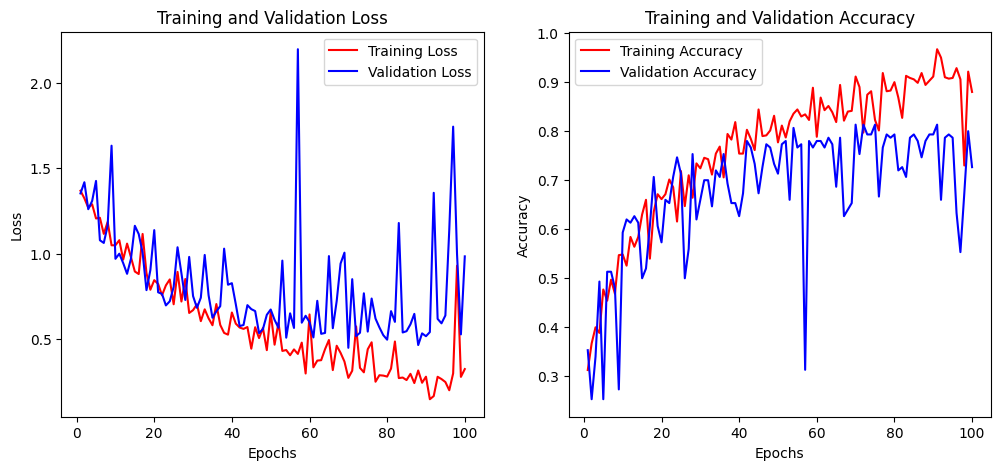

In [23]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'r', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


## Compute the accuracy, precision, recall and f1 score and display the confusion matrix for training, validation and testing sets

22/22 [==============================] - 1s 40ms/step
Training Metrics:
Accuracy: 0.84
Precision: 0.89
Recall: 0.84
F1 Score: 0.84




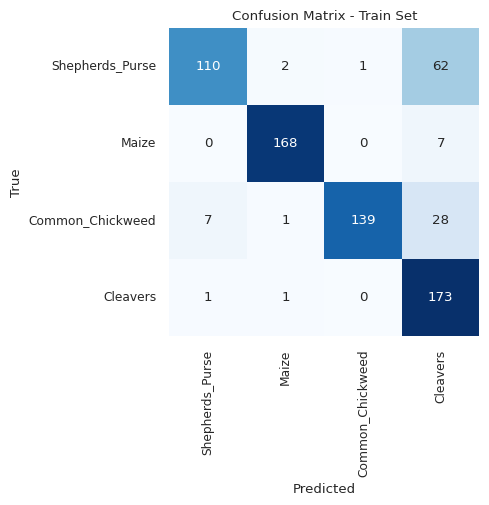

In [24]:
class_labels = ['Shepherds_Purse', 'Maize', 'Common_Chickweed' , 'Cleavers']
y_train_pred = vgg_model_transfer.predict(X_train_c).argmax(axis=1)

train_accuracy = accuracy_score(y_train_c, y_train_pred)
train_precision = precision_score(y_train_c, y_train_pred , average = "macro")
train_recall = recall_score(y_train_c, y_train_pred , average = "macro")
train_f1 = f1_score(y_train_c, y_train_pred , average = "macro")

print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision: {train_precision:.2f}")
print(f"Recall: {train_recall:.2f}")
print(f"F1 Score: {train_f1:.2f}")
print()
print()
plot_confusion_matrix(y_train_c, y_train_pred, class_labels, 'Train Set')


5/5 [==============================] - 0s 38ms/step
Validation Metrics:
Accuracy: 0.73
Precision: 0.77
Recall: 0.72
F1 Score: 0.71




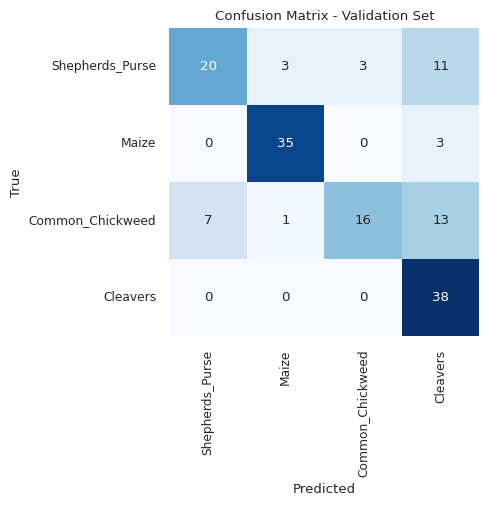

In [25]:
y_val_pred = vgg_model_transfer.predict(X_val_c).argmax(axis=1)

val_accuracy = accuracy_score(y_val_c, y_val_pred)
val_precision = precision_score(y_val_c, y_val_pred , average = "macro")
val_recall = recall_score(y_val_c, y_val_pred , average = "macro")
val_f1 = f1_score(y_val_c, y_val_pred , average = "macro")

print("Validation Metrics:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Precision: {val_precision:.2f}")
print(f"Recall: {val_recall:.2f}")
print(f"F1 Score: {val_f1:.2f}")
print()
print()
plot_confusion_matrix(y_val_c, y_val_pred, class_labels, 'Validation Set')


5/5 [==============================] - 0s 39ms/step
Test Metrics:
Accuracy: 0.70
Precision: 0.77
Recall: 0.70
F1 Score: 0.69




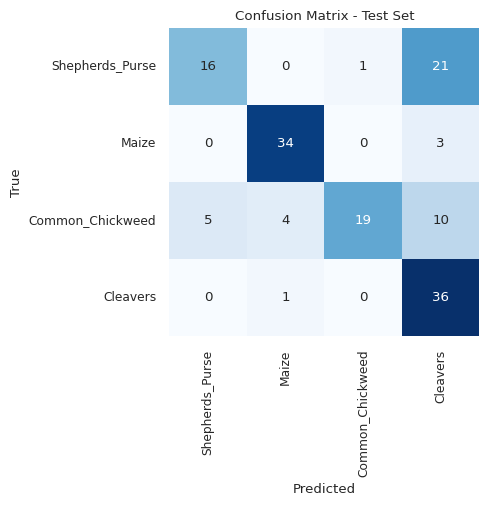

In [26]:
y_test_pred = vgg_model_transfer.predict(X_test_c).argmax(axis=1)

test_accuracy = accuracy_score(y_test_c, y_test_pred )
test_precision = precision_score(y_test_c, y_test_pred , average = "macro")
test_recall = recall_score(y_test_c, y_test_pred , average = "macro")
test_f1 = f1_score(y_test_c, y_test_pred , average = "macro")

print("Test Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1 Score: {test_f1:.2f}")
print()
print()
plot_confusion_matrix(y_test_c, y_test_pred, class_labels, 'Test Set')

# 3.2- Regression Network

## Rean the JSON file

In [27]:
json = pd.read_json("/content/a3_dataset/bbox.json")
json

,Common_Chickweed,Cleavers,Maize,Shepherds_Purse
0,"{'width': 426, 'height': 457}","{'width': 124, 'height': 106}","{'width': 684, 'height': 458}","{'width': 105, 'height': 140}"
1,"{'width': 88, 'height': 217}","{'width': 250, 'height': 209}","{'width': 38, 'height': 35}","{'width': 92, 'height': 110}"
2,"{'width': 40, 'height': 63}","{'width': 64, 'height': 128}","{'width': 641, 'height': 302}","{'width': 114, 'height': 58}"
3,"{'width': 61, 'height': 87}","{'width': 146, 'height': 75}","{'width': 74, 'height': 58}","{'width': 85, 'height': 135}"
4,"{'width': 237, 'height': 472}","{'width': 517, 'height': 426}","{'width': 1002, 'height': 1277}","{'width': 348, 'height': 278}"
...,...,...,...,...
245,"{'width': 161, 'height': 48}","{'width': 440, 'height': 474}","{'width': 43, 'height': 31}","{'width': 405, 'height': 474}"
246,"{'width': 348, 'height': 299}","{'width': 279, 'height': 175}","{'width': 82, 'height': 98}","{'width': 52, 'height': 38}"
247,"{'width': 329, 'height': 332}","{'width': 289, 'height': 258}","{'width': 167, 'height': 87}","{'width': 64, 'height': 99}"
248,"{'width': 123, 'height': 134}","{'width': 568, 'height': 340}","{'width': 499, 'height': 530}","{'width': 134, 'height': 134}"


## Extract the width and height from the dataframe for ech category and save it in separate dataframes

In [28]:
sp_df = pd.DataFrame(json["Shepherds_Purse"])

sp_df['Width'] = sp_df['Shepherds_Purse'].apply(lambda x: x['width'])
sp_df['Height'] = sp_df['Shepherds_Purse'].apply(lambda x: x['height'])


m_df = pd.DataFrame(json["Maize"])

m_df['Width'] = m_df['Maize'].apply(lambda x: x['width'])
m_df['Height'] = m_df['Maize'].apply(lambda x: x['height'])


cc_df = pd.DataFrame(json["Common_Chickweed"])

cc_df['Width'] = cc_df['Common_Chickweed'].apply(lambda x: x['width'])
cc_df['Height'] = cc_df['Common_Chickweed'].apply(lambda x: x['height'])

c_df = pd.DataFrame(json["Cleavers"])

c_df['Width'] = c_df['Cleavers'].apply(lambda x: x['width'])
c_df['Height'] = c_df['Cleavers'].apply(lambda x: x['height'])

## Sort the images dataframe for each category to be from 0 to 249 as the images names

In [29]:
data['Label'] = data['Label'].map(label_mapping)
sorted_df = pd.DataFrame(columns=data.columns)

labels = ["Shepherds_Purse" , "Maize", "Common_Chickweed", "Cleavers" ]

for label in labels:
    category_df = data[data['Label'] == label]

    category_df['Image Index'] = category_df['Image Filename'].str.extract(r'(\d+)').astype(int)

    sorted_category_df = category_df.sort_values(by='Image Index')

    sorted_category_df.reset_index(drop=True, inplace=True)

    sorted_df = pd.concat([sorted_df, sorted_category_df], ignore_index=True)

sorted_df = sorted_df.drop(columns=['Image Index'])

sorted_df


,Image,Resized Image,Label,Image Filename
0,"[[[173, 176, 184], [172, 175, 184], [172, 175,...","[[[0.6780493642769607, 0.6893851485906863, 0.7...",Shepherds_Purse,0.png
1,"[[[76, 61, 49], [78, 63, 51], [77, 63, 49], [7...","[[[0.29819216260723036, 0.23939927045036766, 0...",Shepherds_Purse,1.png
2,"[[[71, 51, 30], [69, 49, 29], [67, 46, 26], [6...","[[[0.2784316119025735, 0.20000023935355393, 0....",Shepherds_Purse,2.png
3,"[[[96, 67, 47], [97, 66, 48], [95, 64, 45], [9...","[[[0.37698531805300245, 0.26220284256280635, 0...",Shepherds_Purse,3.png
4,"[[[65, 52, 39], [68, 55, 40], [79, 66, 50], [8...","[[[0.2775457964423367, 0.2248090137381856, 0.1...",Shepherds_Purse,4.png
...,...,...,...,...
995,"[[[80, 65, 55], [82, 68, 58], [84, 70, 60], [7...","[[[0.32726282246229793, 0.26600192898288955, 0...",Cleavers,245.png
996,"[[[89, 77, 71], [90, 79, 72], [90, 80, 73], [9...","[[[0.3486012615746481, 0.30639771500205787, 0....",Cleavers,246.png
997,"[[[92, 77, 69], [99, 85, 77], [104, 91, 83], [...","[[[0.37871386925554673, 0.3233474287223591, 0....",Cleavers,247.png
998,"[[[138, 128, 120], [132, 120, 111], [127, 115,...","[[[0.4993436728366475, 0.4637643370938717, 0.4...",Cleavers,248.png


## For each category i created a new 2 columns for width and height then concatenate the 4 categories together in one dataframe

In [30]:
sp = sorted_df[sorted_df ["Label"] == "Shepherds_Purse"]
sp["Width"] = sp_df["Width"].values
sp["Height"] = sp_df["Height"].values

m = sorted_df[sorted_df ["Label"] == "Maize"]
m["Width"] = m_df["Width"].values
m["Height"] = m_df["Height"].values


cc = sorted_df[sorted_df ["Label"] == "Common_Chickweed"]
cc["Width"] = cc_df["Width"].values
cc["Height"] = cc_df["Height"].values


c = sorted_df[sorted_df ["Label"] == "Cleavers"]
c["Width"] = c_df["Width"].values
c["Height"] = c_df["Height"].values

new_data = pd.concat([sp, m, cc, c], axis=0, ignore_index=True)
new_data

,Image,Resized Image,Label,Image Filename,Width,Height
0,"[[[173, 176, 184], [172, 175, 184], [172, 175,...","[[[0.6780493642769607, 0.6893851485906863, 0.7...",Shepherds_Purse,0.png,105,140
1,"[[[76, 61, 49], [78, 63, 51], [77, 63, 49], [7...","[[[0.29819216260723036, 0.23939927045036766, 0...",Shepherds_Purse,1.png,92,110
2,"[[[71, 51, 30], [69, 49, 29], [67, 46, 26], [6...","[[[0.2784316119025735, 0.20000023935355393, 0....",Shepherds_Purse,2.png,114,58
3,"[[[96, 67, 47], [97, 66, 48], [95, 64, 45], [9...","[[[0.37698531805300245, 0.26220284256280635, 0...",Shepherds_Purse,3.png,85,135
4,"[[[65, 52, 39], [68, 55, 40], [79, 66, 50], [8...","[[[0.2775457964423367, 0.2248090137381856, 0.1...",Shepherds_Purse,4.png,348,278
...,...,...,...,...,...,...
995,"[[[80, 65, 55], [82, 68, 58], [84, 70, 60], [7...","[[[0.32726282246229793, 0.26600192898288955, 0...",Cleavers,245.png,440,474
996,"[[[89, 77, 71], [90, 79, 72], [90, 80, 73], [9...","[[[0.3486012615746481, 0.30639771500205787, 0....",Cleavers,246.png,279,175
997,"[[[92, 77, 69], [99, 85, 77], [104, 91, 83], [...","[[[0.37871386925554673, 0.3233474287223591, 0....",Cleavers,247.png,289,258
998,"[[[138, 128, 120], [132, 120, 111], [127, 115,...","[[[0.4993436728366475, 0.4637643370938717, 0.4...",Cleavers,248.png,568,340


## Extract the real width and height for each image from its shape in a new 2 columns Image Width, Height

In [31]:
new_data['Image Shape'] = new_data['Image'].apply(lambda x: x.shape)


new_data['Image Width'] = new_data['Image Shape'].apply(lambda x: x[1])
new_data['Image Height'] = new_data['Image Shape'].apply(lambda x: x[0])
new_data

,Image,Resized Image,Label,Image Filename,Width,Height,Image Shape,Image Width,Image Height
0,"[[[173, 176, 184], [172, 175, 184], [172, 175,...","[[[0.6780493642769607, 0.6893851485906863, 0.7...",Shepherds_Purse,0.png,105,140,"(156, 156, 3)",156,156
1,"[[[76, 61, 49], [78, 63, 51], [77, 63, 49], [7...","[[[0.29819216260723036, 0.23939927045036766, 0...",Shepherds_Purse,1.png,92,110,"(126, 126, 3)",126,126
2,"[[[71, 51, 30], [69, 49, 29], [67, 46, 26], [6...","[[[0.2784316119025735, 0.20000023935355393, 0....",Shepherds_Purse,2.png,114,58,"(130, 130, 3)",130,130
3,"[[[96, 67, 47], [97, 66, 48], [95, 64, 45], [9...","[[[0.37698531805300245, 0.26220284256280635, 0...",Shepherds_Purse,3.png,85,135,"(151, 151, 3)",151,151
4,"[[[65, 52, 39], [68, 55, 40], [79, 66, 50], [8...","[[[0.2775457964423367, 0.2248090137381856, 0.1...",Shepherds_Purse,4.png,348,278,"(364, 364, 3)",364,364
...,...,...,...,...,...,...,...,...,...
995,"[[[80, 65, 55], [82, 68, 58], [84, 70, 60], [7...","[[[0.32726282246229793, 0.26600192898288955, 0...",Cleavers,245.png,440,474,"(490, 490, 3)",490,490
996,"[[[89, 77, 71], [90, 79, 72], [90, 80, 73], [9...","[[[0.3486012615746481, 0.30639771500205787, 0....",Cleavers,246.png,279,175,"(295, 295, 3)",295,295
997,"[[[92, 77, 69], [99, 85, 77], [104, 91, 83], [...","[[[0.37871386925554673, 0.3233474287223591, 0....",Cleavers,247.png,289,258,"(305, 305, 3)",305,305
998,"[[[138, 128, 120], [132, 120, 111], [127, 115,...","[[[0.4993436728366475, 0.4637643370938717, 0.4...",Cleavers,248.png,568,340,"(584, 584, 3)",584,584


## Normalize the width and height for each image by divide them over the real shape of the image and save them in a new column

In [32]:
new_data["Normalized Width"] = new_data["Width"] / new_data["Image Width"]
new_data["Normalized Height"] = new_data["Height"] / new_data["Image Height"]
new_data

,Image,Resized Image,Label,Image Filename,Width,Height,Image Shape,Image Width,Image Height,Normalized Width,Normalized Height
0,"[[[173, 176, 184], [172, 175, 184], [172, 175,...","[[[0.6780493642769607, 0.6893851485906863, 0.7...",Shepherds_Purse,0.png,105,140,"(156, 156, 3)",156,156,0.673077,0.897436
1,"[[[76, 61, 49], [78, 63, 51], [77, 63, 49], [7...","[[[0.29819216260723036, 0.23939927045036766, 0...",Shepherds_Purse,1.png,92,110,"(126, 126, 3)",126,126,0.730159,0.873016
2,"[[[71, 51, 30], [69, 49, 29], [67, 46, 26], [6...","[[[0.2784316119025735, 0.20000023935355393, 0....",Shepherds_Purse,2.png,114,58,"(130, 130, 3)",130,130,0.876923,0.446154
3,"[[[96, 67, 47], [97, 66, 48], [95, 64, 45], [9...","[[[0.37698531805300245, 0.26220284256280635, 0...",Shepherds_Purse,3.png,85,135,"(151, 151, 3)",151,151,0.562914,0.894040
4,"[[[65, 52, 39], [68, 55, 40], [79, 66, 50], [8...","[[[0.2775457964423367, 0.2248090137381856, 0.1...",Shepherds_Purse,4.png,348,278,"(364, 364, 3)",364,364,0.956044,0.763736
...,...,...,...,...,...,...,...,...,...,...,...
995,"[[[80, 65, 55], [82, 68, 58], [84, 70, 60], [7...","[[[0.32726282246229793, 0.26600192898288955, 0...",Cleavers,245.png,440,474,"(490, 490, 3)",490,490,0.897959,0.967347
996,"[[[89, 77, 71], [90, 79, 72], [90, 80, 73], [9...","[[[0.3486012615746481, 0.30639771500205787, 0....",Cleavers,246.png,279,175,"(295, 295, 3)",295,295,0.945763,0.593220
997,"[[[92, 77, 69], [99, 85, 77], [104, 91, 83], [...","[[[0.37871386925554673, 0.3233474287223591, 0....",Cleavers,247.png,289,258,"(305, 305, 3)",305,305,0.947541,0.845902
998,"[[[138, 128, 120], [132, 120, 111], [127, 115,...","[[[0.4993436728366475, 0.4637643370938717, 0.4...",Cleavers,248.png,568,340,"(584, 584, 3)",584,584,0.972603,0.582192


## Split the new data as 70 % training and 15 % for each validation and testing sets

In [33]:
train_data, temp_data = train_test_split(new_data, test_size=0.3, random_state=42, stratify=data["Label"])
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data["Label"])

train_data.reset_index(drop=True, inplace=True)
validation_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

print("Train set size:", len(train_data))
print("Validation set size:", len(validation_data))
print("Test set size:", len(test_data))


Train set size: 700
Validation set size: 150
Test set size: 150


In [34]:
print("Training data : \n")
print()
print(train_data["Label"].value_counts())
print()
print("------------------------------------")
print()
print("Validation data : \n")
print()
print(validation_data["Label"].value_counts())
print()
print("------------------------------------")
print()
print("Testing data : \n")
print()
print(test_data["Label"].value_counts())

Training data : 


Maize               175
Shepherds_Purse     175
Cleavers            175
Common_Chickweed    175
Name: Label, dtype: int64

------------------------------------

Validation data : 


Common_Chickweed    38
Shepherds_Purse     38
Cleavers            37
Maize               37
Name: Label, dtype: int64

------------------------------------

Testing data : 


Cleavers            38
Maize               38
Common_Chickweed    37
Shepherds_Purse     37
Name: Label, dtype: int64


## Split the data into X and Y for the model

In [35]:
X_train_r = np.array([np.array(img) for img in train_data["Resized Image"]])
y_train_r = np.array(train_data[["Normalized Width" , "Normalized Height"]])

X_val_r = np.array([np.array(img) for img in validation_data["Resized Image"]])
y_val_r = np.array(validation_data[["Normalized Width" , "Normalized Height"]])

X_test_r = np.array([np.array(img) for img in test_data["Resized Image"]])
y_test_r = np.array(test_data[["Normalized Width" , "Normalized Height"]])


## Build the model

In [36]:
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))



In [37]:
for layer in vgg_model.layers:
    layer.trainable = False

x = vgg_model.layers[-1].output
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)

x = Dense(2, activation='linear')(x)

vgg_model_regression = Model(inputs=vgg_model.input, outputs=x)
print(vgg_model_regression.summary())


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

## Fit the data into the model

In [38]:
sgd = SGD(lr=0.0008)
vgg_model_regression.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mean_squared_error'])

batchSize = 32
nEpochs = 100

history = vgg_model_regression.fit(X_train_r, y_train_r, batch_size=batchSize, epochs=nEpochs, verbose=1,
                                   validation_data=(X_val_r, y_val_r))

Epoch 1/100
22/22 [==============================] - 3s 74ms/step - loss: 0.6637 - mean_squared_error: 0.6637 - val_loss: 0.0527 - val_mean_squared_error: 0.0527
Epoch 2/100
22/22 [==============================] - 1s 59ms/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0390 - val_mean_squared_error: 0.0390
Epoch 3/100
22/22 [==============================] - 1s 59ms/step - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0398 - val_mean_squared_error: 0.0398
Epoch 4/100
22/22 [==============================] - 1s 54ms/step - loss: 0.0387 - mean_squared_error: 0.0387 - val_loss: 0.0413 - val_mean_squared_error: 0.0413
Epoch 5/100
22/22 [==============================] - 1s 62ms/step - loss: 0.0382 - mean_squared_error: 0.0382 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 6/100
22/22 [==============================] - 1s 64ms/step - loss: 0.0375 - mean_squared_error: 0.0375 - val_loss: 0.0375 - val_mean_squared_error: 0.0375
Epoch 7/100
22/22 [=========

## Plot the learning curves for both training and validation sets

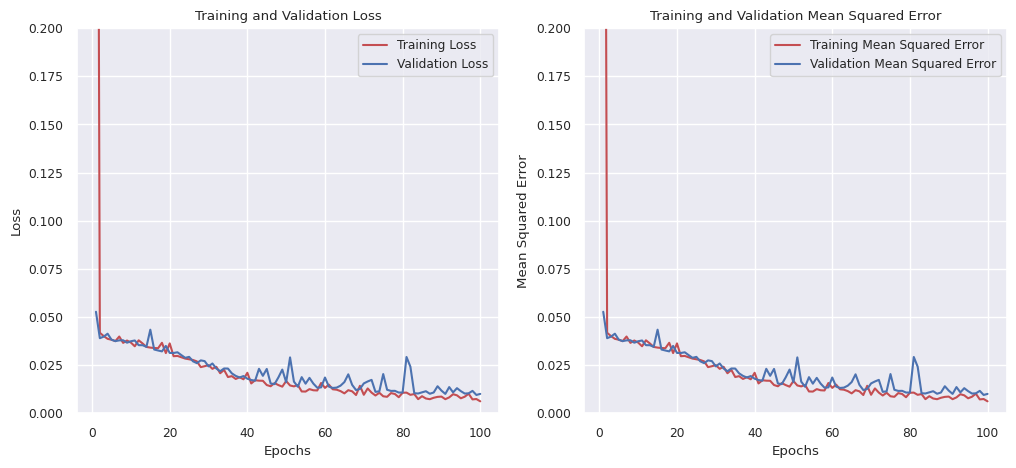

In [39]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['mean_squared_error']
validation_accuracy = history.history['val_mean_squared_error']

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'r', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.2)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'r', label='Training Mean Squared Error')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Mean Squared Error')
plt.title('Training and Validation Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.ylim(0, 0.2)
plt.legend()

plt.show()


## Print the mean squared error for training, validation and testing sets

In [40]:
y_train_pred = vgg_model_regression.predict(X_train_r)

train_mse = mean_squared_error(y_train_r, y_train_pred)


print("Training Metrics:")
print(f"Mean Squared Error (MSE) : {train_mse}")
print()

22/22 [==============================] - 1s 43ms/step
Training Metrics:
Mean Squared Error (MSE) : 0.006155581415123567



In [41]:
y_val_pred = vgg_model_regression.predict(X_val_r)

val_mse = mean_squared_error(y_val_r, y_val_pred)


print("Validation Metrics:")
print(f"Mean Squared Error (MSE) : {val_mse}")
print()

5/5 [==============================] - 0s 38ms/step
Validation Metrics:
Mean Squared Error (MSE) : 0.010049799184235642



In [42]:
y_test_pred = vgg_model_regression.predict(X_test_r)

test_mse = mean_squared_error(y_test_r, y_test_pred)


print("Testing Metrics:")
print(f"Mean Squared Error (MSE) : {test_mse}")
print()

5/5 [==============================] - 0s 39ms/step
Testing Metrics:
Mean Squared Error (MSE) : 0.010950337938198725



# 4- Model Improvement

## Classification Network

### Build the model

In [53]:
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))

for layer in vgg_model.layers:
    layer.trainable = False

x = vgg_model.layers[-1].output
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)

x = WeightNormalization(Dense(64, activation='relu'))(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = WeightNormalization(Dense(4, activation='softmax'))(x)

vgg_model_transfer = Model(inputs=vgg_model.input, outputs=x)
sgd = SGD(lr=0.0008)
vgg_model_transfer.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

batchSize = 32
nEpochs = 100

history = vgg_model_transfer.fit(X_train_c, y_train_c, batch_size=batchSize, epochs=nEpochs, verbose=1,
                                 validation_data=(X_val_c, y_val_c))


Epoch 1/100
22/22 [==============================] - 9s 145ms/step - loss: 4.5452 - accuracy: 0.2643 - val_loss: 1.4469 - val_accuracy: 0.2467
Epoch 2/100
22/22 [==============================] - 1s 68ms/step - loss: 1.5105 - accuracy: 0.2543 - val_loss: 1.3789 - val_accuracy: 0.3667
Epoch 3/100
22/22 [==============================] - 1s 67ms/step - loss: 1.4398 - accuracy: 0.2929 - val_loss: 1.3930 - val_accuracy: 0.2467
Epoch 4/100
22/22 [==============================] - 2s 72ms/step - loss: 1.4032 - accuracy: 0.3214 - val_loss: 1.2829 - val_accuracy: 0.3600
Epoch 5/100
22/22 [==============================] - 2s 71ms/step - loss: 1.4794 - accuracy: 0.3171 - val_loss: 1.4293 - val_accuracy: 0.2600
Epoch 6/100
22/22 [==============================] - 2s 70ms/step - loss: 1.4645 - accuracy: 0.3157 - val_loss: 1.3877 - val_accuracy: 0.2533
Epoch 7/100
22/22 [==============================] - 2s 69ms/step - loss: 1.3997 - accuracy: 0.3243 - val_loss: 1.2505 - val_accuracy: 0.4067
Epoch

### Display the learning curves for both training and validation sets

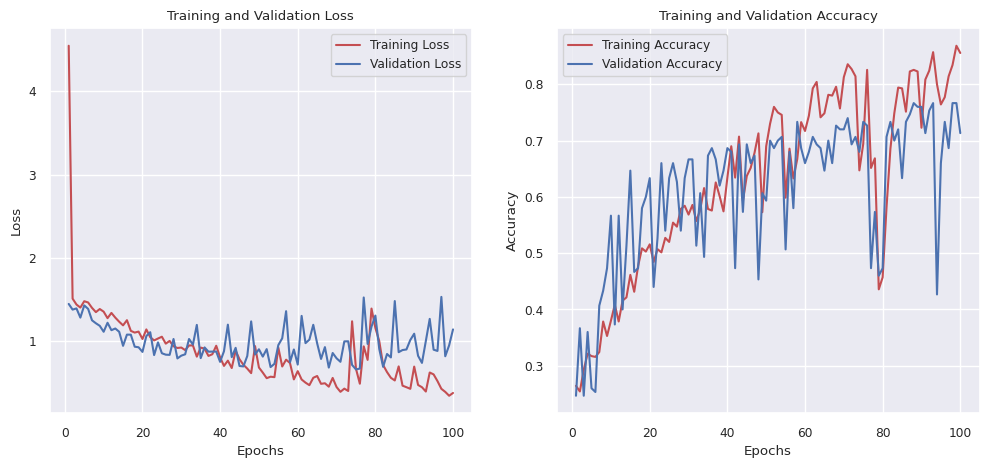

In [54]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'r', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


### Compute the accuracy, precision, recall and f1 score and display the confusion matrix for training, validation and testing sets

22/22 [==============================] - 1s 45ms/step
Training Metrics:
Accuracy: 0.93
Precision: 0.93
Recall: 0.93
F1 Score: 0.93




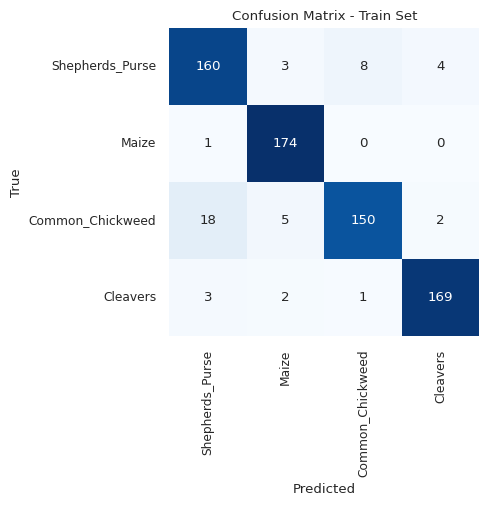

In [55]:
class_labels = ['Shepherds_Purse', 'Maize', 'Common_Chickweed' , 'Cleavers']
y_train_pred = vgg_model_transfer.predict(X_train_c).argmax(axis=1)

train_accuracy = accuracy_score(y_train_c, y_train_pred)
train_precision = precision_score(y_train_c, y_train_pred , average = "macro")
train_recall = recall_score(y_train_c, y_train_pred , average = "macro")
train_f1 = f1_score(y_train_c, y_train_pred , average = "macro")

print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision: {train_precision:.2f}")
print(f"Recall: {train_recall:.2f}")
print(f"F1 Score: {train_f1:.2f}")
print()
print()
plot_confusion_matrix(y_train_c, y_train_pred, class_labels, 'Train Set')


5/5 [==============================] - 0s 69ms/step
Validation Metrics:
Accuracy: 0.71
Precision: 0.72
Recall: 0.71
F1 Score: 0.70




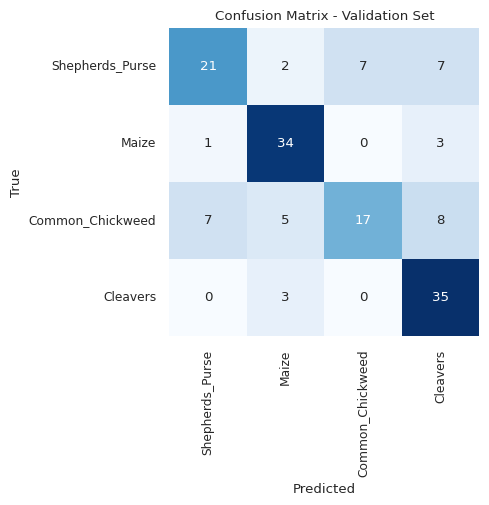

In [56]:
y_val_pred = vgg_model_transfer.predict(X_val_c).argmax(axis=1)

val_accuracy = accuracy_score(y_val_c, y_val_pred)
val_precision = precision_score(y_val_c, y_val_pred , average = "macro")
val_recall = recall_score(y_val_c, y_val_pred , average = "macro")
val_f1 = f1_score(y_val_c, y_val_pred , average = "macro")

print("Validation Metrics:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Precision: {val_precision:.2f}")
print(f"Recall: {val_recall:.2f}")
print(f"F1 Score: {val_f1:.2f}")
print()
print()
plot_confusion_matrix(y_val_c, y_val_pred, class_labels, 'Validation Set')


5/5 [==============================] - 0s 55ms/step
Test Metrics:
Accuracy: 0.82
Precision: 0.83
Recall: 0.82
F1 Score: 0.82




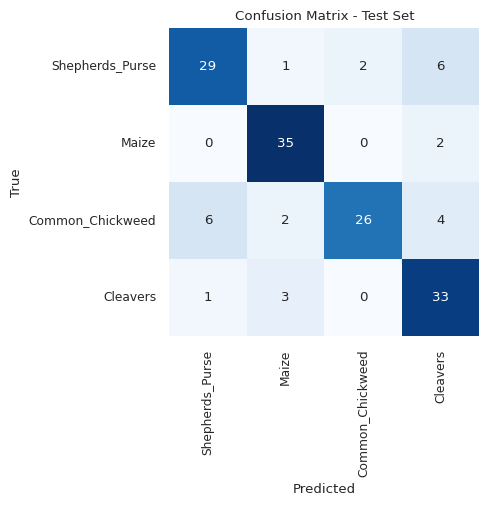

In [57]:
y_test_pred = vgg_model_transfer.predict(X_test_c).argmax(axis=1)

test_accuracy = accuracy_score(y_test_c, y_test_pred )
test_precision = precision_score(y_test_c, y_test_pred , average = "macro")
test_recall = recall_score(y_test_c, y_test_pred , average = "macro")
test_f1 = f1_score(y_test_c, y_test_pred , average = "macro")

print("Test Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1 Score: {test_f1:.2f}")
print()
print()
plot_confusion_matrix(y_test_c, y_test_pred, class_labels, 'Test Set')

## Regression Network

### Build the model

In [48]:
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))

for layer in vgg_model.layers:
    layer.trainable = False


x = vgg_model.layers[-1].output
x = Dense(256,  activation='relu')(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dense(2, activation='linear')(x)


vgg_model_regression = Model(inputs=vgg_model.input, outputs=x)

sgd = SGD(lr=0.0008)
vgg_model_regression.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mean_squared_error'])

batchSize = 32
nEpochs = 50

history = vgg_model_regression.fit(X_train_r, y_train_r, batch_size=batchSize, epochs=nEpochs, verbose=1,
                                   validation_data=(X_val_r, y_val_r))


Epoch 1/50
22/22 [==============================] - 4s 83ms/step - loss: 0.5308 - mean_squared_error: 0.5308 - val_loss: 0.2593 - val_mean_squared_error: 0.2593
Epoch 2/50
22/22 [==============================] - 1s 57ms/step - loss: 0.2689 - mean_squared_error: 0.2689 - val_loss: 0.1818 - val_mean_squared_error: 0.1818
Epoch 3/50
22/22 [==============================] - 1s 62ms/step - loss: 0.1966 - mean_squared_error: 0.1966 - val_loss: 0.1059 - val_mean_squared_error: 0.1059
Epoch 4/50
22/22 [==============================] - 1s 62ms/step - loss: 0.1666 - mean_squared_error: 0.1666 - val_loss: 0.0980 - val_mean_squared_error: 0.0980
Epoch 5/50
22/22 [==============================] - 1s 58ms/step - loss: 0.1430 - mean_squared_error: 0.1430 - val_loss: 0.1010 - val_mean_squared_error: 0.1010
Epoch 6/50
22/22 [==============================] - 1s 58ms/step - loss: 0.1341 - mean_squared_error: 0.1341 - val_loss: 0.1156 - val_mean_squared_error: 0.1156
Epoch 7/50
22/22 [================

### Plot the learning curves for both training and validation sets

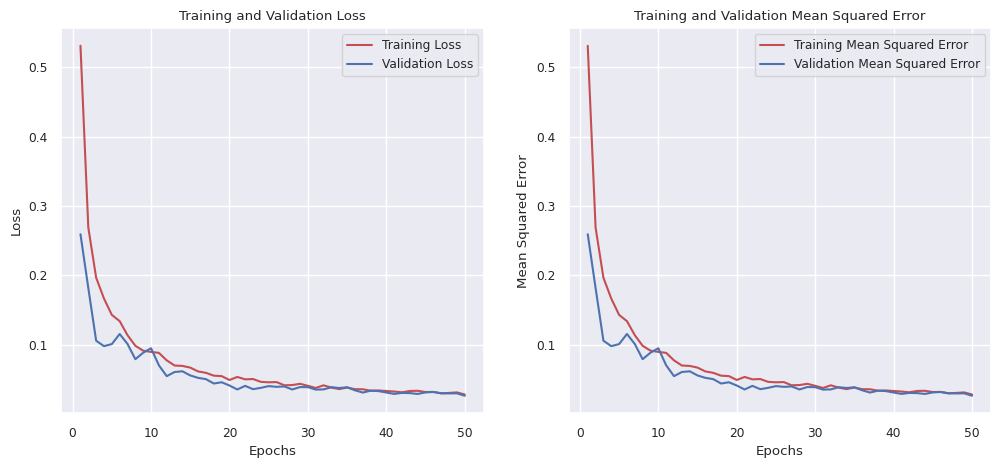

In [49]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['mean_squared_error']
validation_accuracy = history.history['val_mean_squared_error']

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'r', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.ylim(0, 0.4)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'r', label='Training Mean Squared Error')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Mean Squared Error')
plt.title('Training and Validation Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
# plt.ylim(0, 0.4)
plt.legend()

plt.show()


### Print the mean squared error for training, validation and testing sets

In [50]:
y_train_pred = vgg_model_regression.predict(X_train_r)

train_mse = mean_squared_error(y_train_r, y_train_pred)


print("Training Metrics:")
print(f"Mean Squared Error (MSE) : {train_mse}")
print()

22/22 [==============================] - 1s 48ms/step
Training Metrics:
Mean Squared Error (MSE) : 0.014181533758109831



In [51]:
y_val_pred = vgg_model_regression.predict(X_val_r)

val_mse = mean_squared_error(y_val_r, y_val_pred)


print("Validation Metrics:")
print(f"Mean Squared Error (MSE) : {val_mse}")
print()

5/5 [==============================] - 0s 46ms/step
Validation Metrics:
Mean Squared Error (MSE) : 0.026584065548919646



In [52]:
y_test_pred = vgg_model_regression.predict(X_test_r)

test_mse = mean_squared_error(y_test_r, y_test_pred)


print("Testing Metrics:")
print(f"Mean Squared Error (MSE) : {test_mse}")
print()

5/5 [==============================] - 0s 45ms/step
Testing Metrics:
Mean Squared Error (MSE) : 0.02511045000172946



# **5- Discussion**

## Classification Network


### **Overfitting is likely occurring in both Model1 and Model2, especially given the small dataset size. Overfitting is a common concern when working with limited data, as models tend to memorize the training set rather than generalize. In this case, both models have complex architectures with numerous parameters, making them susceptible to overfitting. The significant gap between training accuracy and validation/test accuracy, particularly in Model2, is indicative of this issue. While regularization techniques are in place to mitigate overfitting, the small dataset size remains a challenge.**
------------------------------------------------------------------
### **According to the learning curves there is no obvious overfitting because of they are changing together although the difference between the curves is slightly small**
------------------------------------------------------------------
### **regularization has improved training performance in Model2, as seen in its higher training accuracy, but it hasn't necessarily led to a significant improvement in generalization performance on validation and test data.**

## Regression Network

### **As in classification network overfitting is happening in both models because of the limited data size and the gap between training and testing/validation MSE is indicative of this issue**
-------------------------------------------------
### **According to the learning curves there is no obvious overfitting because of they are changing together although the difference between the curves is slightly small**
-------------------------------------------------
### **The regularization techniques used in Model2, such as BatchNormalization and Dropout, don't appear to be effectively mitigating the overfitting problem**